### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

In [1]:
## !git merge 

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from os import walk

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from scipy import stats

#### Load all sheets in the underlying file

In [3]:
file_path = '../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

file_list = []
for (dirpath, dirnames, filenames) in walk(file_path):
    file_list.extend(filenames)
    break

file_list = [x for x in file_list if x[-3:] == 'csv']

In [4]:
##sheet = client.open('Learning Log').sheet1

raw_df = pd.DataFrame()
for file_name in file_list:
    sub_table = pd.read_csv(file_path + file_name)
    sub_table['sheet_name'] = file_name.split('.')[0]
    raw_df = pd.concat([raw_df, sub_table])

raw_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name
0,Hubei,Mainland China,2020-02-18T23:13:11,61682.0,1921.0,9128.0,02-18-2020
1,Guangdong,Mainland China,2020-02-18T13:43:02,1328.0,4.0,565.0,02-18-2020
2,Henan,Mainland China,2020-02-18T14:23:02,1257.0,19.0,522.0,02-18-2020
3,Zhejiang,Mainland China,2020-02-18T12:23:02,1172.0,0.0,535.0,02-18-2020
4,Hunan,Mainland China,2020-02-18T13:43:02,1007.0,4.0,527.0,02-18-2020


In [5]:
raw_df.describe(include=[np.object])

,Province/State,Country/Region,Last Update,sheet_name
count,1595,2195,2195,2195
unique,71,38,635,33
top,Shandong,Mainland China,1/31/2020 23:59,02-23-2020
freq,33,1017,62,85


In [6]:
# Merge duplicate columns with different names

main_df = raw_df

# main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

# main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

# main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update', '',
                                                'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'
                                                'Announcement'])]

## main_df = main_df.drop(columns=['Announcement',
                      ## 'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])

main_df.sample(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name
25,Jilin,Mainland China,2020-02-09T09:03:04,78.0,1.0,12.0,02-09-2020
42,UK,UK,2020-02-12T19:03:06,9.0,0.0,1.0,02-15-2020
25,Tianjin,Mainland China,2020-02-23T12:43:02,135.0,3.0,81.0,02-23-2020
39,Philippines,Philippines,1/23/20 17:00,NaN,NaN,NaN,01-23-2020
35,Malaysia,Malaysia,2020-02-13T10:53:02,19.0,0.0,3.0,02-14-2020


In [7]:
main_df.sheet_name.str.split('-')

0     [02, 18, 2020]
1     [02, 18, 2020]
2     [02, 18, 2020]
3     [02, 18, 2020]
4     [02, 18, 2020]
           ...      
62    [02, 01, 2020]
63    [02, 01, 2020]
64    [02, 01, 2020]
65    [02, 01, 2020]
66    [02, 01, 2020]
Name: sheet_name, Length: 2195, dtype: object

In [8]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('-').apply(lambda x: x[0])
main_df['day'] = main_df.sheet_name.str.split('-').apply(lambda x: x[1])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
# main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau','Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

In [9]:
main_df

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name,month,day
0,Hubei,Mainland China,2020-02-18 21:13:11,61682.0,1921.0,9128.0,02-18-2020,02,18
1,Guangdong,Mainland China,2020-02-18 11:43:02,1328.0,4.0,565.0,02-18-2020,02,18
2,Henan,Mainland China,2020-02-18 12:23:02,1257.0,19.0,522.0,02-18-2020,02,18
3,Zhejiang,Mainland China,2020-02-18 10:23:02,1172.0,0.0,535.0,02-18-2020,02,18
4,Hunan,Mainland China,2020-02-18 11:43:02,1007.0,4.0,527.0,02-18-2020,02,18
...,...,...,...,...,...,...,...,...,...
62,"Los Angeles, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
63,"Orange, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
64,"Santa Clara, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
65,"Seattle, WA",US,2020-02-01 17:43:00,1.0,0.0,0.0,02-01-2020,02,01


In [10]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  ## 'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period
0,Australia,Australia,01,23,2020-01-23 15:00:00,0.0,0.0,0.0,2020-01-23
1,Australia,Australia,01,25,2020-01-25 15:00:00,4.0,0.0,0.0,2020-01-25
2,Australia,Australia,01,26,2020-01-26 14:00:00,4.0,0.0,0.0,2020-01-26
3,Australia,From Diamond Princess,02,21,2020-02-21 21:03:13,4.0,0.0,0.0,2020-02-21
4,Australia,From Diamond Princess,02,22,2020-02-22 15:03:05,7.0,0.0,0.0,2020-02-22
...,...,...,...,...,...,...,...,...,...
2190,Vietnam,Vietnam,02,19,2020-02-13 04:33:02,16.0,7.0,0.0,2020-02-19
2191,Vietnam,Vietnam,02,20,2020-02-13 04:33:02,16.0,7.0,0.0,2020-02-20
2192,Vietnam,Vietnam,02,21,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-21
2193,Vietnam,Vietnam,02,22,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-22


#### Some baisc checks

2020-01-22 15:00:00    38
2020-01-23 15:00:00    46
2020-01-24 15:00:00    41
2020-01-25 15:00:00    44
2020-01-26 14:00:00    47
                       ..
2020-02-23 21:03:08     1
2020-02-23 21:13:05     1
2020-02-23 21:23:03     1
2020-02-23 21:33:07     2
2020-02-23 21:43:02     1
Name: Last Update, Length: 634, dtype: int64

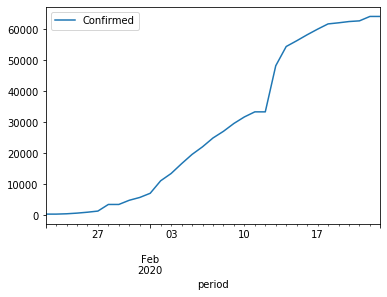

In [11]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [12]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Ashland, NE                             1
Ivory Coast                             1
Brazil                                  1
Mexico                                  1
Travis, CA                              1
Lackland, TX                            1
Colombia                                1
Chicago                                 1
Lackland, TX (From Diamond Princess)    2
Travis, CA (From Diamond Princess)      2
None                                    2
Lebanon                                 2
Cruise Ship                             2
Omaha, NE (From Diamond Princess)       2
Australia                               3
Humboldt County, CA                     3
Sacramento County, CA                   3
Bavaria                                 4
Iran                                    5
California                              6
Name: Province/State, dtype: int64

In [13]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Ashland, NE', 'Ivory Coast', 'Brazil', 'Mexico', 'Travis, CA',
       'Lackland, TX', 'Colombia', 'Chicago',
       'Lackland, TX (From Diamond Princess)',
       'Travis, CA (From Diamond Princess)'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

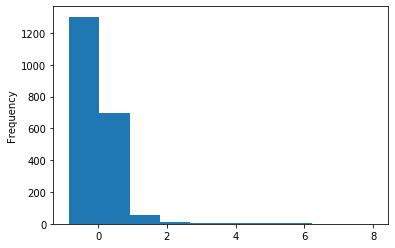

In [14]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [15]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
35,Australia,Queensland,01,31,2020-01-31 21:59:00,2.0,0.0,0.0,2020-01-31,3.0,-1.0,-0.333333
37,Australia,Queensland,02,02,2020-02-02 20:33:07,2.0,0.0,0.0,2020-02-02,3.0,-1.0,-0.333333
394,Israel,From Diamond Princess,02,21,2020-02-21 13:33:03,1.0,0.0,0.0,2020-02-21,7.0,-6.0,-0.857143
423,Japan,Japan,01,23,2020-01-23 15:00:00,1.0,0.0,0.0,2020-01-23,2.0,-1.0,-0.500000
438,Japan,Japan,02,07,2020-02-07 02:13:20,25.0,1.0,0.0,2020-02-07,45.0,-20.0,-0.444444


In [16]:
# focus on cases where base is above 8
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 8]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,1028.040678,159.290678,26.271186,962.020339,66.020339,0.125825,14.265254
std,6185.992655,980.144622,197.800709,5908.081065,546.288931,0.244299,8.388569
min,8.000000,0.000000,0.000000,8.000000,-20.000000,-0.444444,1.000000
25%,28.000000,1.000000,0.000000,24.000000,0.000000,0.000000,7.000000
50%,100.500000,11.000000,0.000000,90.000000,4.000000,0.039912,14.000000
75%,326.500000,59.000000,1.000000,303.750000,16.000000,0.141348,21.000000
max,64084.000000,15343.000000,2346.000000,64084.000000,14840.000000,2.555556,32.000000


In [17]:
growth_df = heavy_affect_df.pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').reset_index()
growth_df

Province/State,day count,Anhui,Beijing,Chongqing,Cruise Ship,Diamond Princess cruise ship,France,Fujian,Gansu,Germany,...,South Korea,Taiwan,Thailand,Tianjin,UK,United Arab Emirates,Vietnam,Xinjiang,Yunnan,Zhejiang
0,1.0,0.666667,0.571429,2.000000,0.0,1.109375,0.000000,0.800000,0.357143,0.250000,...,0.090909,0.000000,0.000000,0.250000,0.000,0.000000,0.000000,0.300000,0.454545,1.700000
1,2.0,1.600000,0.636364,1.111111,NaN,0.000000,0.000000,0.944444,0.263158,0.200000,...,0.250000,0.125000,0.750000,0.400000,0.125,0.000000,0.000000,0.076923,0.625000,0.592593
2,3.0,0.538462,0.138889,0.315789,NaN,0.296296,0.000000,0.685714,0.083333,0.000000,...,0.000000,0.111111,0.000000,0.642857,0.000,0.000000,0.250000,0.214286,0.692308,0.441860
3,4.0,0.166667,0.658537,0.466667,NaN,0.000000,0.000000,0.355932,0.115385,0.000000,...,0.066667,0.000000,0.000000,0.043478,0.000,0.000000,0.000000,0.058824,0.250000,0.677419
4,5.0,0.514286,0.176471,0.200000,NaN,0.245714,0.000000,0.050000,0.379310,0.000000,...,0.187500,0.000000,0.357143,0.125000,0.000,0.000000,0.300000,0.166667,0.272727,0.230769
5,6.0,0.433962,0.137500,0.113636,NaN,0.307339,0.000000,0.202381,0.275000,0.083333,...,0.210526,0.000000,0.000000,0.148148,0.000,0.125000,0.000000,0.142857,0.185714,0.351562
6,7.0,0.315789,0.219780,0.238095,NaN,0.245614,0.090909,0.188119,0.078431,0.000000,...,0.043478,0.100000,0.000000,0.032258,0.000,0.000000,0.076923,0.208333,0.120482,0.710983
7,8.0,0.185000,0.027027,0.159341,NaN,0.278873,0.000000,0.200000,0.036364,0.076923,...,0.000000,0.000000,0.000000,0.281250,0.000,0.000000,0.071429,0.103448,0.129032,0.445946
8,9.0,0.253165,0.219298,0.170616,NaN,0.193833,0.000000,0.104167,0.087719,0.000000,...,0.041667,0.454545,0.315789,0.170732,0.000,0.000000,0.000000,0.125000,0.114286,0.257009
9,10.0,0.144781,0.208633,0.214575,NaN,0.145756,0.000000,0.125786,0.000000,0.142857,...,0.080000,0.000000,0.000000,0.250000,0.000,0.000000,0.066667,0.083333,0.042735,0.113383


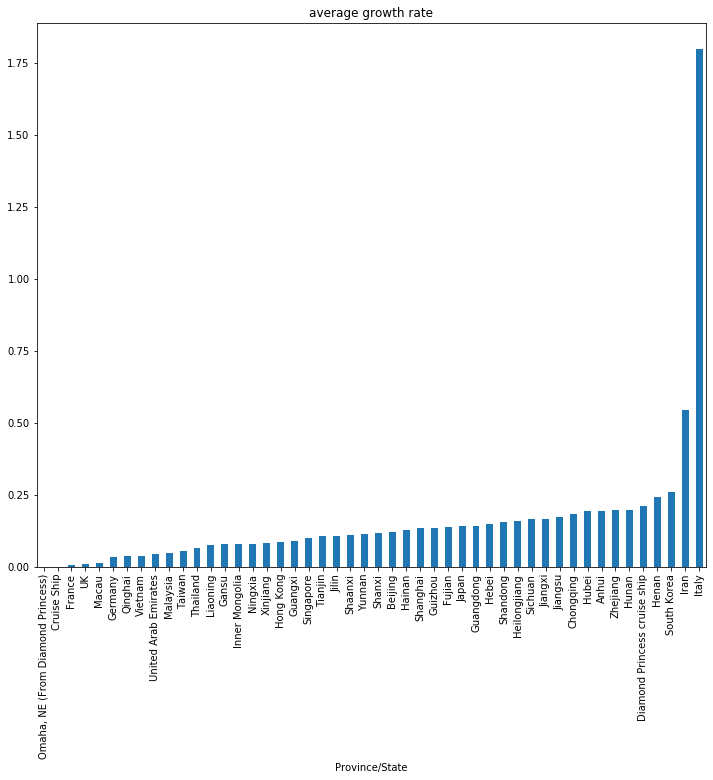

In [18]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().sort_values().plot.bar(figsize=(12,10),
                                                              title='average growth rate')

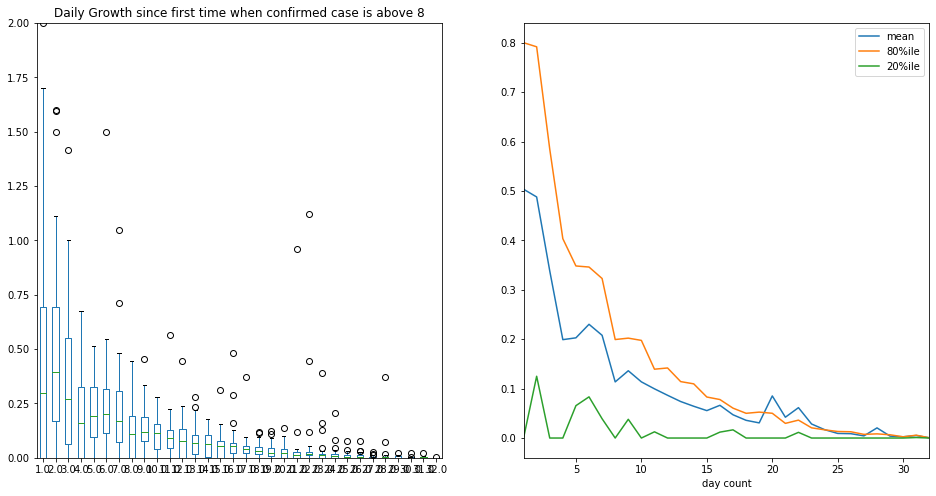

In [19]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize =(16,8))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [20]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
17,Hubei,444.0
4,Diamond Princess cruise ship,135.0
21,Italy,62.0
3,Cruise Ship,61.0
15,Henan,32.0


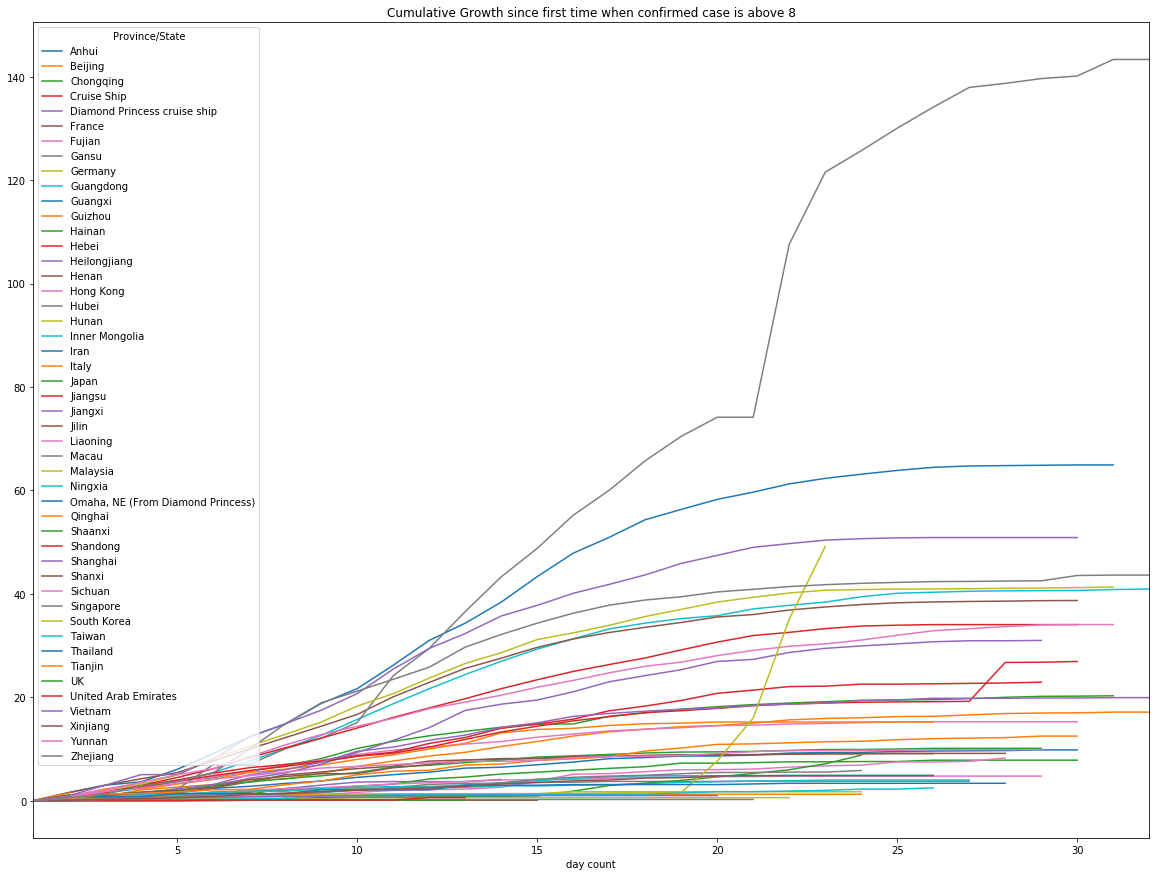

In [21]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')

cmlt_growth_df.plot.line(figsize =(20, 15), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

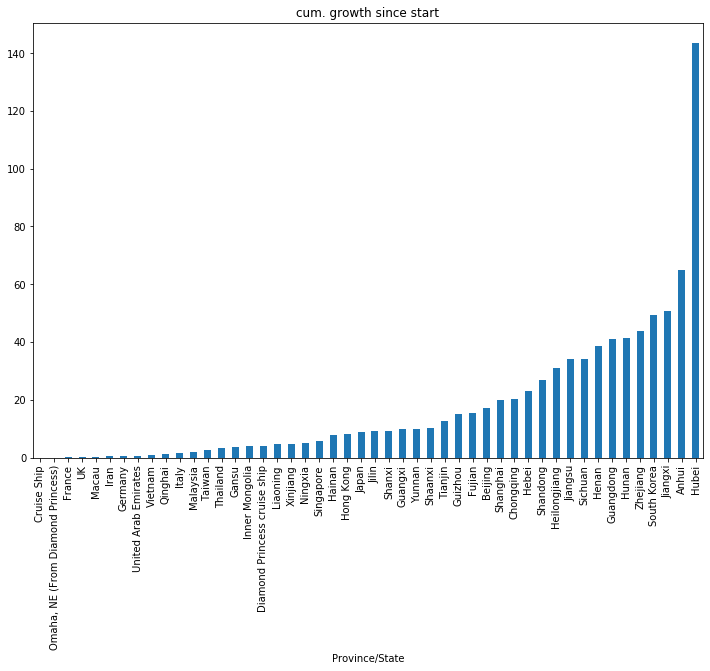

In [22]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8), title='cum. growth since start')

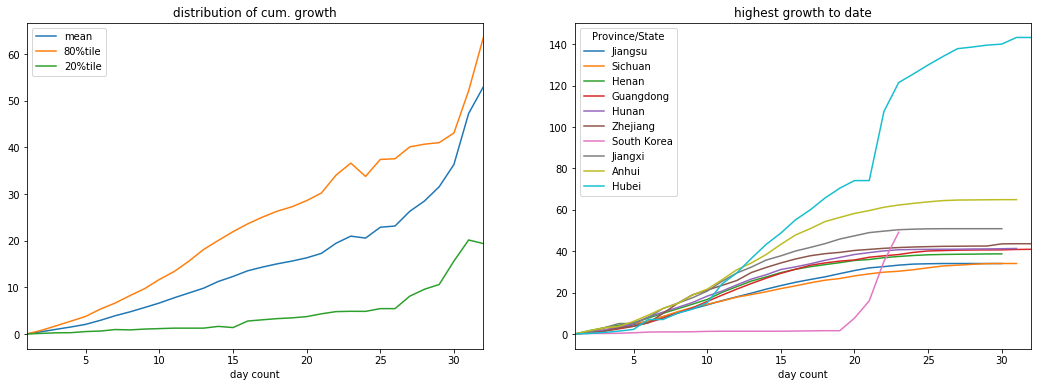

In [23]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['mean','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'highest growth to date')

#### Compare China vs. Outside

In [24]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [25]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

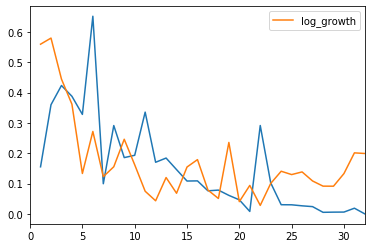

In [26]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

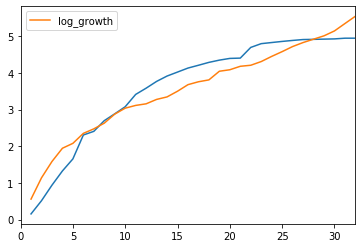

In [27]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [28]:
# The null hypothesis that the two distribution the same can't be reject by a simple T-test
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=-0.5081891277399674, pvalue=0.6131241309836217)

#### Time-series Analysis on Growth Rate

In [29]:
# auto-correlation is high in China 🇨🇳  on aggregate
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.00000000e+00  5.32208458e-01  5.78497573e-01  4.77798899e-01
  3.42228857e-01  3.07949332e-01  2.14580738e-01  1.79335960e-01
  1.47462755e-01  8.58209438e-02  3.19329726e-03  4.73241101e-02
 -4.48863641e-02 -1.17106881e-01 -1.17571680e-01 -2.33197949e-01
 -8.20461916e-02 -1.70898864e-01 -2.02058419e-01 -1.89918906e-01
 -1.99147854e-01 -2.77507922e-01 -2.74844929e-01 -2.71496163e-01
 -2.76806426e-01 -2.46287928e-01 -2.71751345e-01 -1.70468958e-01
 -1.36255514e-01 -9.18709074e-02 -4.20974374e-02 -1.80288544e-04]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   32
Model:                     AutoReg(1)   Log Likelihood                  18.934
Method:               Conditional MLE   S.D. of innovations              0.131
Date:                Mon, 24 Feb 2020   AIC                             -3.866
Time:                        09:24:08   BIC                             -3.727
Sample:                             1   HQIC                            -3.821
                                   32                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0668      0.034      1.963      0.050       0.000       0.133
log_growth.L1     0.5501      0.154      3.582      0.000       0.249       0.851
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8179           +0.0000j            1.8179            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
# auto-correlation is quite high outside of China
print(acf(outside_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is significant
model = AutoReg(outside_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.646023    0.42729569  0.24025617  0.11414611  0.13130883
  0.09614079  0.10859197  0.02674905 -0.07225098 -0.11253818 -0.132021
 -0.08770309 -0.05888887 -0.08730605 -0.05152216 -0.13431351 -0.09573268
 -0.12079634 -0.2432168  -0.21141226 -0.1836889  -0.09959629 -0.09054813
 -0.11299679 -0.12622822 -0.14714248 -0.12155112 -0.06013733  0.00523596
  0.03665575  0.01718785]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   32
Model:                     AutoReg(1)   Log Likelihood                  35.158
Method:               Conditional MLE   S.D. of innovations              0.078
Date:                Mon, 24 Feb 2020   AIC                             -4.913
Time:                        09:24:08   BIC                             -4.774
Sample:                             1   HQIC                            -4.867
                                   32                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0494      0.022      2.202      0.028       0.005       0.093
log_growth.L1     0.6462      0.102      6.355      0.000       0.447       0.846
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5474           +0.0000j            1.5474            0.0000
-----------------------------------------------------------------------------
"""

#### Predictive Models for Singapore

In [31]:
outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index()

,Country/Region,Province/State,period,Confirmed,Recovered,Deaths
0,Australia,Australia,2020-01-23,0.0,0.0,0.0
1,Australia,Australia,2020-01-25,4.0,0.0,0.0
2,Australia,Australia,2020-01-26,4.0,0.0,0.0
3,Australia,From Diamond Princess,2020-02-21,4.0,0.0,0.0
4,Australia,From Diamond Princess,2020-02-22,7.0,0.0,0.0
...,...,...,...,...,...,...
1173,Vietnam,Vietnam,2020-02-19,16.0,7.0,0.0
1174,Vietnam,Vietnam,2020-02-20,16.0,7.0,0.0
1175,Vietnam,Vietnam,2020-02-21,16.0,14.0,0.0
1176,Vietnam,Vietnam,2020-02-22,16.0,14.0,0.0


In [32]:
# user econometric model given 1) small dataset and 2) preference for confidence interval

In [33]:
model_df = growth_df[growth_df.index <= growth_df[growth_df['Singapore'].isna() == False].index.max()].set_index('day count')
model_df = model_df.dropna(axis=1)
model_df

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shanghai,Shanxi,Sichuan,Singapore,Taiwan,Thailand,Tianjin,Xinjiang,Yunnan,Zhejiang
day count,,,,,,,,,,,,,,,,,,,,,
1.0,0.666667,0.571429,2.000000,0.800000,0.357143,0.230769,0.000000,0.000000,1.375000,0.625000,...,0.777778,0.444444,0.875000,0.300000,0.000000,0.000000,0.250000,0.300000,0.454545,1.700000
2.0,1.600000,0.636364,1.111111,0.944444,0.263158,0.656250,0.565217,0.333333,0.157895,0.384615,...,0.250000,1.076923,0.866667,0.230769,0.125000,0.750000,0.400000,0.076923,0.625000,0.592593
3.0,0.538462,0.138889,0.315789,0.685714,0.083333,0.471698,0.277778,1.416667,0.500000,0.833333,...,0.650000,0.000000,0.571429,0.125000,0.111111,0.000000,0.642857,0.214286,0.692308,0.441860
4.0,0.166667,0.658537,0.466667,0.355932,0.115385,0.423077,0.108696,0.000000,0.212121,0.454545,...,0.212121,0.296296,0.568182,0.000000,0.000000,0.000000,0.043478,0.058824,0.250000,0.677419
5.0,0.514286,0.176471,0.200000,0.050000,0.379310,0.360360,0.137255,0.310345,0.075000,0.354167,...,0.325000,0.114286,0.304348,0.333333,0.000000,0.357143,0.125000,0.166667,0.272727,0.230769
6.0,0.433962,0.137500,0.113636,0.202381,0.275000,0.370861,0.344828,0.210526,0.069767,0.261538,...,0.245283,0.205128,0.200000,0.166667,0.000000,0.000000,0.148148,0.142857,0.185714,0.351562
7.0,0.315789,0.219780,0.238095,0.188119,0.078431,0.338164,0.115385,0.260870,0.130435,0.170732,...,0.454545,0.404255,0.314815,0.000000,0.100000,0.000000,0.032258,0.208333,0.120482,0.710983
8.0,0.185000,0.027027,0.159341,0.200000,0.036364,0.277978,0.149425,0.103448,0.192308,0.083333,...,0.166667,0.121212,0.246479,0.071429,0.000000,0.000000,0.281250,0.103448,0.129032,0.445946
9.0,0.253165,0.219298,0.170616,0.104167,0.087719,0.231638,0.110000,0.109375,0.032258,0.086538,...,0.205357,0.094595,0.169492,0.100000,0.454545,0.315789,0.170732,0.125000,0.114286,0.257009


In [34]:
model_df.corr()['Singapore'].sort_values(ascending=False).head(10)

Province/State
Singapore    1.000000
Gansu        0.722415
Shandong     0.662035
Hunan        0.647506
Jiangsu      0.629371
Anhui        0.612550
Henan        0.596302
Xinjiang     0.593596
Shaanxi      0.588611
Chongqing    0.564579
Name: Singapore, dtype: float64

In [35]:
var_model = VAR(model_df[['Singapore','Hong Kong']])
results = var_model.fit(maxlags=1)
results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Feb, 2020
Time:                     09:24:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.27416
Nobs:                     23.0000    HQIC:                  -9.49588
Log likelihood:           50.7882    FPE:                6.99739e-05
AIC:                     -9.57038    Det(Omega_mle):     5.47577e-05
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.074827         0.028253            2.648           0.008
L1.Singapore         0.363336         0.193173            1.881           0.060
L1.Hong Kong        -0.218888         0.187623           -1.

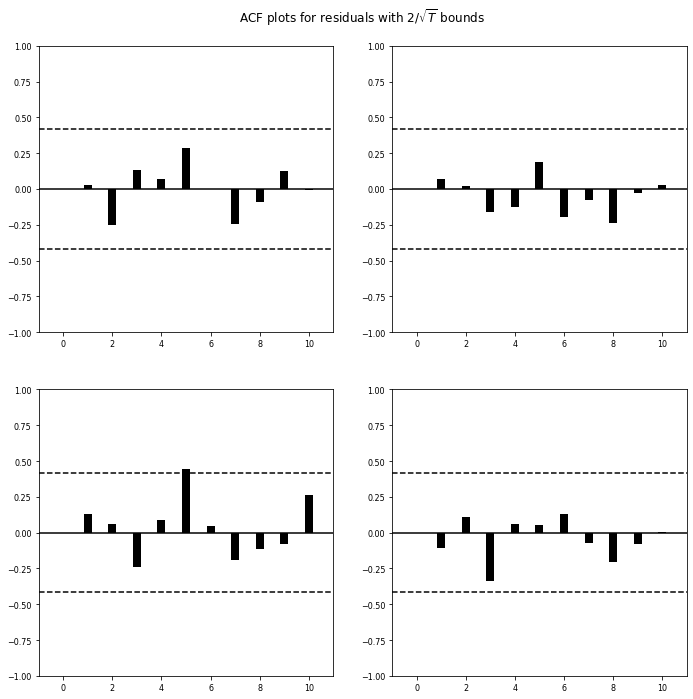

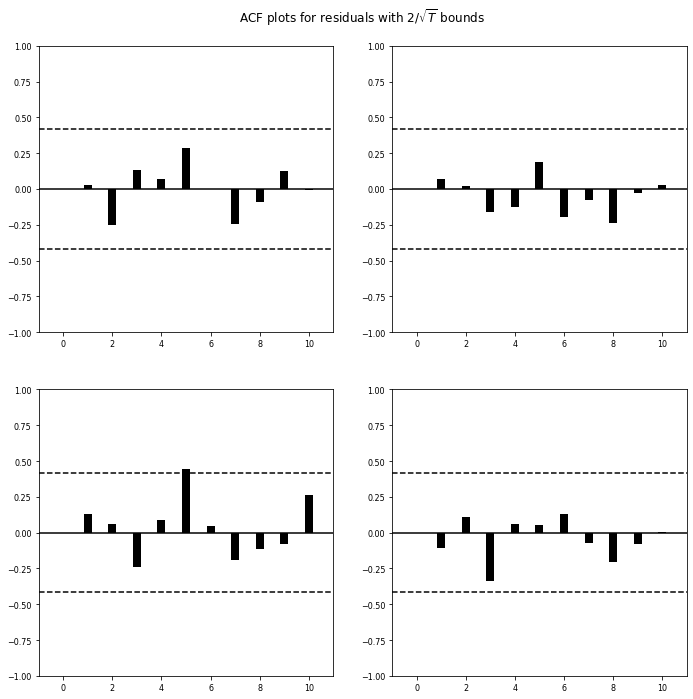

In [36]:
results.plot_acorr()

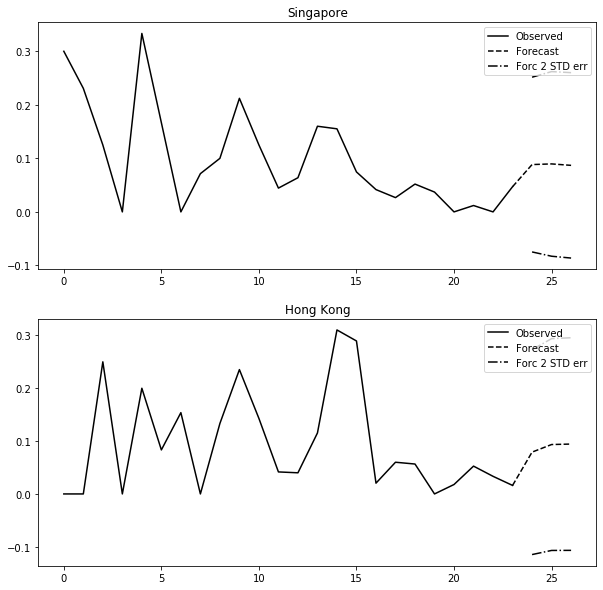

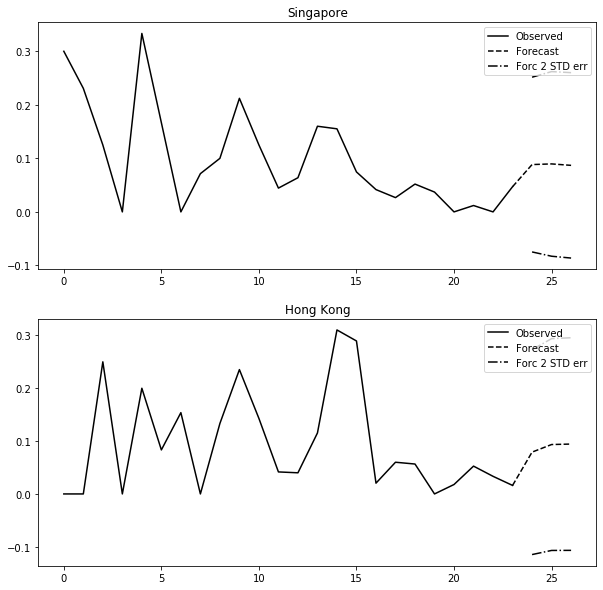

In [37]:
# Make forecast
results.plot_forecast(3)

In [38]:
# model_df[['Singapore','Hong Kong']]

# fcst_df

# fcst_df.loc[10,['Singapore','Hong Kong']].values

# np.array(fcst)

# np.array(fcst).flatten()

In [39]:
# day to be forecasted
day_forecat = model_df.index.max() + 1

In [40]:
fcst = results.forecast_interval(model_df[['Singapore','Hong Kong']].values[-2:,:], 1)

In [41]:
fcst_df = heavy_affect_df[heavy_affect_df['Province/State'].isin(['Singapore','Hong Kong'])].pivot(index ='day count',
                                                                                         columns = 'Province/State',
                                                                                        values = 'Confirmed')

In [42]:
fcst_num = ((np.array(fcst) + 1 ) * fcst_df.loc[day_forecat-1,['Singapore','Hong Kong']].values).flatten()

In [43]:
fcst_df['Singapore_f_m'] = np.nan
fcst_df['Hong Kong_f_m'] = np.nan
fcst_df['Singapore_f_lo'] = np.nan
fcst_df['Hong Kong_f_lo'] = np.nan
fcst_df['Singapore_f_up'] = np.nan
fcst_df['Hong Kong_f_up'] = np.nan

fcst_df.loc[day_forecat,['Singapore_f_m','Hong Kong_f_m','Singapore_f_lo',
                'Hong Kong_f_lo','Singapore_f_up','Hong Kong_f_up']] = fcst_num

fcst_df.loc[day_forecat - 1, ['Singapore_f_m','Singapore_f_lo','Singapore_f_up']] = fcst_df.loc[day_forecat - 1,'Singapore']
fcst_df.loc[day_forecat - 1, ['Hong Kong_f_m','Hong Kong_f_lo','Hong Kong_f_up']] = fcst_df.loc[day_forecat - 1,'Hong Kong']

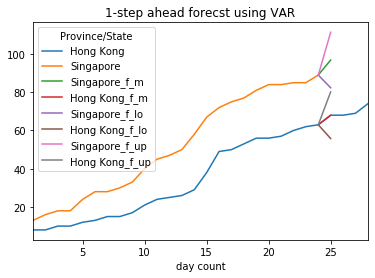

In [44]:
fcst_df.plot.line(title = '1-step ahead forecst using VAR')

### Recover rate using the latest data available

In [45]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Australia,Australia,01,26,2020-01-26 14:00:00,4.0,0.0,0.0,2020-01-26,4.0,0.0,0.000000,0.000000
1,Australia,New South Wales,02,13,2020-02-13 15:53:03,4.0,4.0,0.0,2020-02-13,4.0,0.0,0.000000,1.000000
2,Australia,New South Wales,02,14,2020-02-13 15:53:03,4.0,4.0,0.0,2020-02-14,4.0,0.0,0.000000,1.000000
3,Australia,New South Wales,02,15,2020-02-13 15:53:03,4.0,4.0,0.0,2020-02-15,4.0,0.0,0.000000,1.000000
4,Australia,New South Wales,02,16,2020-02-13 15:53:03,4.0,4.0,0.0,2020-02-16,4.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,United Arab Emirates,United Arab Emirates,02,22,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-22,9.0,4.0,0.444444,0.307692
468,United Arab Emirates,United Arab Emirates,02,23,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-23,13.0,0.0,0.000000,0.307692
469,Vietnam,Vietnam,02,21,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-21,16.0,0.0,0.000000,0.875000
470,Vietnam,Vietnam,02,22,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-22,16.0,0.0,0.000000,0.875000


Recovery over total confirmed cases: 29.91%


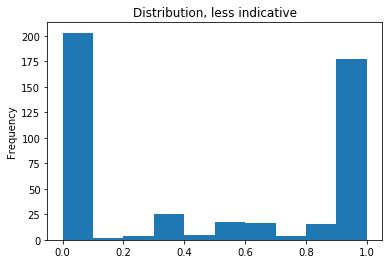

In [46]:
# Recovery rate
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Recovery over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Mortality over total confirmed cases: 3.11%


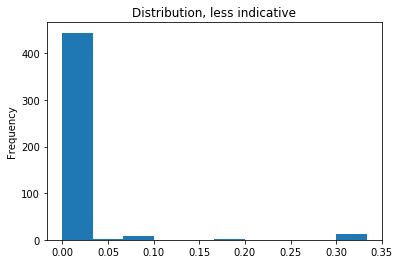

In [47]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df['mortality rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Mortality over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [48]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [49]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)